In [102]:
#загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from scipy import stats as st

In [103]:
pd.set_option('display.max_columns', None) # уберем ограничение по отображению количества столбцов

## 6 Оценка бонусов на поведение пользователей

<div style="border:solid green 2px; padding: 20px">
    
**Цель:** Оценить влияние бонусов на поведение пользователей.

<div style="border:solid yellow 2px; padding: 20px">
    
**Задачи:**
    
   *1. Проверить данные и предобработать (при необходимости)  
    2. Исследовать корреляцию количества бонусов и количество донаций  
    3. Выдвинуть и проверить гипотезу    
    4. Исследовать партнеров и их бонусы  
    5. Провести анализ в разрезе видов крови    
    6. Провести анализ исходя из типа планирования донации  
    7. Анализ по сегментам пользователей в зависимости от количества донаций  
    8. Подготовить вывод по документу  
    9. Добавить ключевые компоненты в итоговую презентацию*
</div>

<div style="border:solid blue 2px; padding: 20px">

**Декомпозиция задачи:**
    
    6. Оценка бонусов на поведение пользователей
        6.1 Загрузка датасетов и предобработка для анализа
        6.2 Проведем анализ
            6.2.1 Корреляция количества бонусов к количеству донаций  
            6.2.2 Выдвижение и проверка гипотезы  
            6.2.3 Изучение партнеров и бонусов  
            6.2.4 Исследование в разрезе разных видов крови  
            6.2.5 Анализ пользователей планирующих / не планирующих донации  
            6.2.6 Сегментация пользователей по количеству донаций
        6.3 ВЫВОД по документу
</div>

<div style="border:solid red 2px; padding: 20px">

Для данного документа отберем данные за 2021, 2022, 2023(до 13 ноября) года.

Возьмем только активных пользователей - т.е. тех, которые хоть раз за этот период совершили какое-либо действие на сайте.

Донации считаем только подтвержденные (загружена справка о донации и модератор ее принял).

Исключим пользователей, о которых есть записи о полученных бонусах, но нет их в списке профелей.

### 6.1 Загрузка датасетов и предобработка для анализа

В работе используем датасет использованных бонусов по ссылке в url_bonus и  датесет пользователей сайта (url_users), а также датасет запланированных донаций (ссылка в url_plan).

In [104]:
url_bonus = 'https://drive.google.com/file/d/1rzxqMKWIveNGcDZdj5E4MBXq2nzZXckV/view'
url_bonus='https://drive.google.com/uc?id=' + url_bonus.split('/')[-2]
bonus = pd.read_csv(url_bonus, index_col=0) # загрузим датасет с использованными бонусами
bonus.head()

,user_id,bonus_count,donation_count,partner,bonus,date,country,region,city
0,132667,15,44,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-23,Россия,Санкт-Петербург,Санкт-Петербург
1,224412,14,31,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-23,Россия,Татарстан,Казань
2,153877,33,53,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-23,Россия,Ивановская область,Вичуга
3,225324,14,9,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-22,Россия,Москва,Москва
4,269612,4,3,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-22,Россия,Омская область,Омск


In [105]:
bonus['date'] = pd.to_datetime(bonus['date']) # преобразуем в тип дататайм

In [106]:
bonus['date'].min() # бонусы начали выдавать с 29 декабря 2020

Timestamp('2020-12-29 00:00:00')

In [107]:
count_nominal_bonus = len(bonus['user_id']) # количество записей

In [108]:
# возьмем для анализа работы в текущем документе данные за 2021, 2022, и неполный 2023 года
bonus = bonus[bonus['date'] >= '2021-01-01 00:00:00']

In [109]:
# а именно до 13 ноября 2023
bonus['date'].max()

Timestamp('2023-11-13 00:00:00')

In [110]:
len(bonus['user_id'].unique()) # количество уникальных пользователей получавших бонусы за указанный период

9200

In [111]:
bonus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20654 entries, 0 to 20671
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         20654 non-null  int64         
 1   bonus_count     20654 non-null  int64         
 2   donation_count  20654 non-null  int64         
 3   partner         20654 non-null  object        
 4   bonus           20654 non-null  object        
 5   date            20654 non-null  datetime64[ns]
 6   country         20654 non-null  object        
 7   region          20654 non-null  object        
 8   city            20654 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 1.6+ MB


In [112]:
url_users = 'https://drive.google.com/file/d/1mPLTsWj9AWkjnYlGXgRygHJMNcfEkRjB/view'
url_users='https://drive.google.com/uc?id=' + url_users.split('/')[-2]
users = pd.read_csv(url_users, index_col=0, low_memory=False) # загрузим датасет с пользователями сайта
users.sample()

,Пол,Дата_рождения,Регион,Группа_крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,Эритроциты,Лейкоциты,Костный мозг,Почетный_донор,Отвод_от_донации,Цельная_кровь.1,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата_регистрации,Не_подтверждённые_донации,Прошедших_донаций,Донаций_до_регистрации,Последняя_активность,Теги,Указан_email,Указан_телефон,Авторизация_через_ВК,Авторизация_через_Одноклассники,Авторизация_через_Твиттер,Авторизация_через_Яндекс,Авторизация_через_Гугл,Подтверждённые_донации,Получен_значок_20,Получен_значок_100,Донаций_на_момент_регистрации,Количество_взятых_бонусов,Дата_получения_почетного_донора,Подтвержденный_почетный_донор,Предполагаемая_дата_получения_почетного_донора
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
116202,NaN,NaN,NaN,NaN,NaN,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2018-04-09,0,0,NaN,NaN,NaN,нет,нет,да,нет,нет,нет,нет,0,нет,нет,NaN,0,NaN,0,NaN


In [113]:
users = users.reset_index(col_level=True) # сбросим индекс, чтобы user_id был колонкой

In [114]:
# изменим тип данных для дат
users['Дата_рождения'] = pd.to_datetime(users['Дата_рождения'])
users['Дата_регистрации'] = pd.to_datetime(users['Дата_регистрации'])
users['Последняя_активность'] = pd.to_datetime(users['Последняя_активность'])
users['Дата_получения_почетного_донора'] = pd.to_datetime(users['Дата_получения_почетного_донора'])
users['Предполагаемая_дата_получения_почетного_донора'] = pd.to_datetime(users['Предполагаемая_дата_получения_почетного_донора'])

In [115]:
# избавимся от ненужных столбцов
users = users[['user_id','Пол','Дата_рождения','Почетный_донор',	'Отвод_от_донации','Цельная_кровь.1','Плазма.1','Тромбоциты.1','Эритроциты.1','Лейкоциты.1','Дата_регистрации',\
       'Донаций_до_регистрации','Последняя_активность','Подтверждённые_донации','Донаций_на_момент_регистрации','Количество_взятых_бонусов','Дата_получения_почетного_донора',\
       'Подтвержденный_почетный_донор']]

In [116]:
users.head()

,user_id,Пол,Дата_рождения,Почетный_донор,Отвод_от_донации,Цельная_кровь.1,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата_регистрации,Донаций_до_регистрации,Последняя_активность,Подтверждённые_донации,Донаций_на_момент_регистрации,Количество_взятых_бонусов,Дата_получения_почетного_донора,Подтвержденный_почетный_донор
0,275790,NaN,NaT,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,NaN,2023-11-23,0,NaN,0,NaT,0
1,275789,Женский,NaT,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,NaN,NaT,0,NaN,0,NaT,0
2,275788,NaN,NaT,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,NaN,2023-11-23,0,NaN,0,NaT,0
3,275787,Мужской,1977-04-29,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,32.0,2023-11-23,0,32.0,0,NaT,0
4,275786,NaN,NaT,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,2.0,2023-11-23,0,2.0,0,NaT,0


In [117]:
len(users['user_id'].unique()) # количество уникальных пользователей в датасете пользователей сайта

265474

In [118]:
count_nominal_users = len(users['user_id']) # количество записей

In [119]:
users = users[users['Последняя_активность'] >= '2021-01-01 00:00:00'] # отфильтруем уже по заданному временному коридору выше
users = users[users['Последняя_активность'] <= '2023-11-13 00:00:00']

In [120]:
users['Последняя_активность'].min() # первая активность выбранных пользователей


Timestamp('2021-01-01 00:00:00')

In [121]:
users['Последняя_активность'].max() # последняя активность выбранных пользователей

Timestamp('2023-11-13 00:00:00')

In [122]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88531 entries, 957 to 265470
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_id                          88531 non-null  int64         
 1   Пол                              49284 non-null  object        
 2   Дата_рождения                    42339 non-null  datetime64[ns]
 3   Почетный_донор                   88531 non-null  object        
 4   Отвод_от_донации                 88531 non-null  object        
 5   Цельная_кровь.1                  88531 non-null  int64         
 6   Плазма.1                         88531 non-null  int64         
 7   Тромбоциты.1                     88531 non-null  int64         
 8   Эритроциты.1                     88531 non-null  int64         
 9   Лейкоциты.1                      88531 non-null  int64         
 10  Дата_регистрации                 88531 non-null  dateti

In [123]:
users.sample()

,user_id,Пол,Дата_рождения,Почетный_донор,Отвод_от_донации,Цельная_кровь.1,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата_регистрации,Донаций_до_регистрации,Последняя_активность,Подтверждённые_донации,Донаций_на_момент_регистрации,Количество_взятых_бонусов,Дата_получения_почетного_донора,Подтвержденный_почетный_донор
89736,181447,Мужской,1969-06-30,Да,Нет,43,0,0,0,0,2022-01-02,NaN,2023-08-23,43,NaN,0,NaT,1


In [124]:
# проверим есть ли пользователи с бонусами и без подтвержденных донаций
list_bag = list(users.query('Подтверждённые_донации == 0 and Количество_взятых_бонусов > 0')['user_id'])
len(list_bag)

16

In [125]:
# удалим их
users = users.query('user_id not in @list_bag')

In [126]:
# проверим все ли пользователи с bonus содержатся в users
list_users = list(users['user_id']) # создадим соответствующие списки
list_bonus = list(bonus['user_id'])
list_users.extend(list_bonus) # добавим пользователей с бонусами в список пользователей сайта
len(set(list_users)) - len(list(users['user_id'])) # вычтем уникальных пользователей из списка пользователей сайта
# 1287 пользователя удалить из bonus, т.к. о них не значатся данные в датасете пользователей сайта

1287

In [127]:
variable = len(set(bonus['user_id'])) # временная переменная для подсчета

In [128]:
bonus = bonus[bonus['user_id'].isin(list(set(users['user_id'])))] # удалим 1287 пользователя из бонус

Мы потеряли 21% записей о получении бонусов или...

In [129]:
print(f"...{round((variable - len(set(bonus['user_id'])))/variable*100,2)}% пользователей.")

...13.99% пользователей.


In [130]:
bonus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16339 entries, 0 to 20671
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         16339 non-null  int64         
 1   bonus_count     16339 non-null  int64         
 2   donation_count  16339 non-null  int64         
 3   partner         16339 non-null  object        
 4   bonus           16339 non-null  object        
 5   date            16339 non-null  datetime64[ns]
 6   country         16339 non-null  object        
 7   region          16339 non-null  object        
 8   city            16339 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 1.2+ MB


In [131]:
users.sample()

,user_id,Пол,Дата_рождения,Почетный_донор,Отвод_от_донации,Цельная_кровь.1,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата_регистрации,Донаций_до_регистрации,Последняя_активность,Подтверждённые_донации,Донаций_на_момент_регистрации,Количество_взятых_бонусов,Дата_получения_почетного_донора,Подтвержденный_почетный_донор
119938,152246,Мужской,2001-11-11,17.11.2025,Нет,4,4,0,0,0,2020-07-28,NaN,2023-04-24,8,NaN,1,NaT,0


In [132]:
users.groupby('Количество_взятых_бонусов')['user_id'].agg('count').to_frame().reset_index().head(5)

,Количество_взятых_бонусов,user_id
0,0,80594
1,1,4437
2,2,1695
3,3,788
4,4,385


In [133]:
# всего пользователей воспользовавшимися бонусами
users.groupby('Количество_взятых_бонусов')['user_id'].agg('count').to_frame().reset_index()['user_id'].sum() - 80594

7921

Видно, что не воспользовались бонусами большинство - 80 594 чел. (за 2021, 2022 и не полный 2023 годы)

In [134]:
print('А именно: ',round((users['user_id'].count()-len(set(bonus['user_id']))) / users['user_id'].count()*100),'% пользователей')

А именно:  91 % пользователей


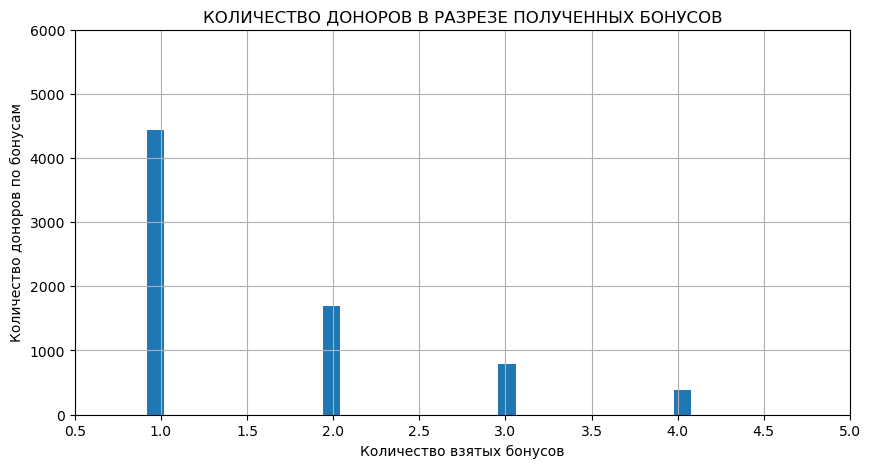

In [135]:
users['Количество_взятых_бонусов'].hist(bins=500)
plt.xlabel('Количество взятых бонусов')
plt.ylabel('Количество доноров по бонусам')
plt.xlim(0.5, 5)
plt.ylim(0, 6000)
plt.title('КОЛИЧЕСТВО ДОНОРОВ В РАЗРЕЗЕ ПОЛУЧЕННЫХ БОНУСОВ')
plt.show()

In [136]:
print(round(len(users['user_id'])/count_nominal_users*100),'% данных осталось в датасете пользователей сайта')
print(round(len(bonus['user_id'])/count_nominal_bonus*100),'% данных осталось в датасете использованных бонусов')

33 % данных осталось в датасете пользователей сайта
79 % данных осталось в датасете использованных бонусов


Пользователей сайта так урезали из-за последней активности, которая была ранее 2021 года.

### 6.2 Проведем анализ

#### 6.2.1 Корреляция количества бонусов к количеству донаций

In [137]:
bonus.sample()

,user_id,bonus_count,donation_count,partner,bonus,date,country,region,city
15234,149555,16,24,Ozon,Подписка Ozon Premium на 1 месяц,2022-07-07,Россия,Москва,Москва


In [138]:
grp_donation_bonus = bonus.groupby(['donation_count'], as_index=False)['bonus_count'].agg('count').reset_index(drop=True)
#grp_tm_day.rename(columns={"airport": "count_strike"}, inplace = True)
grp_donation_bonus

,donation_count,bonus_count
0,0,42
1,1,4714
2,2,2213
3,3,1272
4,4,1028
...,...,...
126,158,9
127,163,1
128,167,4
129,194,2


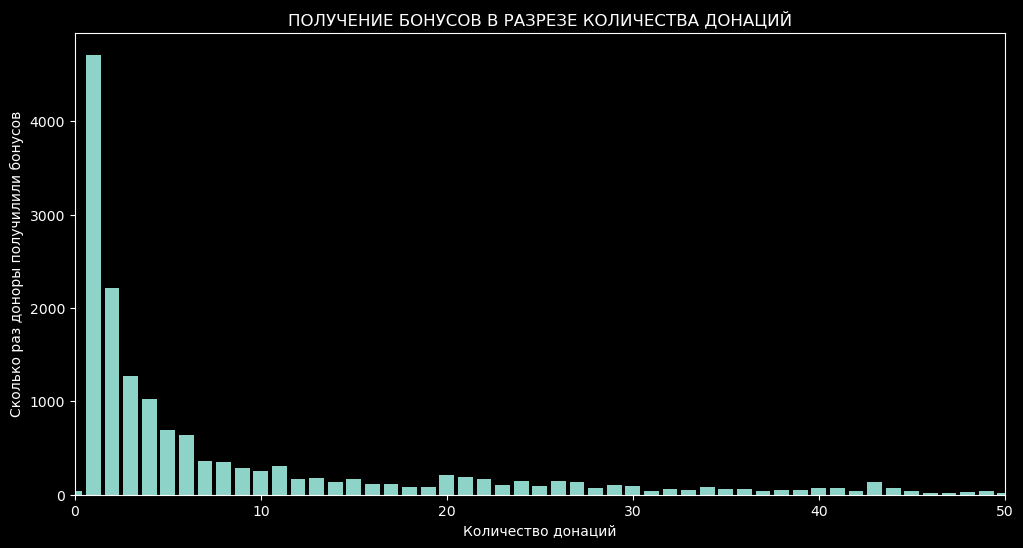

In [139]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(12, 6))
    plt.bar(grp_donation_bonus['donation_count'], grp_donation_bonus['bonus_count'])
    plt.title('ПОЛУЧЕНИЕ БОНУСОВ В РАЗРЕЗЕ КОЛИЧЕСТВА ДОНАЦИЙ')
    plt.xlabel('Количество донаций')
    plt.ylabel('Сколько раз доноры получилили бонусов')
    plt.xlim(0, 50)

plt.show()

Убывающая тенденция, как и ожидалось, от количества донаций.  
Большинство людей получили бонусы при 1 донации - 4 714, при 2 донациях - 2 213, что может свидетельствовать, что как раз эти люди могли быть дополнительно мотивированны бонусами, чтобы сдать кровь.

Те люди, что сдают чаще 6 и более раз, во-первых, их просто меньше, во-вторых, их могут мотивировать совершенно другие мотивы, нежели получение бонусов. Но люди стабильно получают бонусы даже при 50+ количествах донаций, значит для них это важный весомый аргумент.

На следующих шагах нужно посмотреть точечную диаграмму.

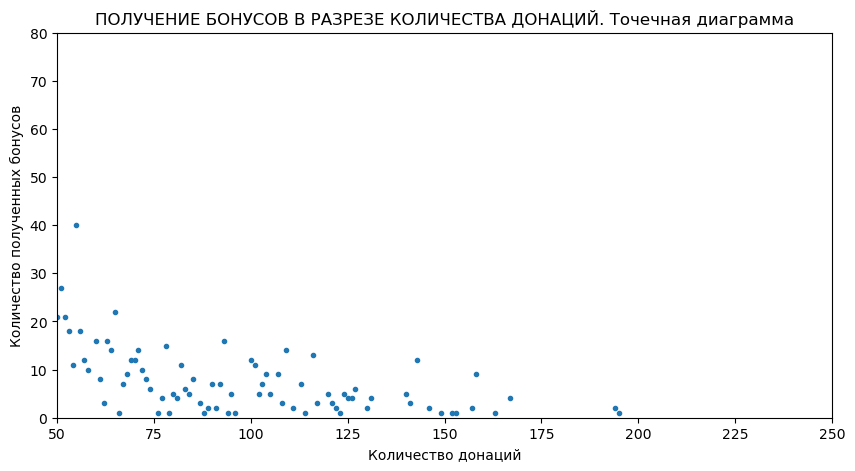

In [140]:
grp_donation_bonus.pivot_table(index='donation_count', values='bonus_count', aggfunc='median').plot(style='.', xlim=(50, 250), ylim=(0, 80))
plt.title('ПОЛУЧЕНИЕ БОНУСОВ В РАЗРЕЗЕ КОЛИЧЕСТВА ДОНАЦИЙ. Точечная диаграмма')
plt.xlabel('Количество донаций')
plt.ylabel('Количество полученных бонусов')
plt.legend('',frameon=False) # удалим легенду
plt.show()

Этот график отражает тот, что выше, только точечная диаграмма.

Ниже смотрим агрегацию чисто по донациям и количеству полученных бонусов по медиане:

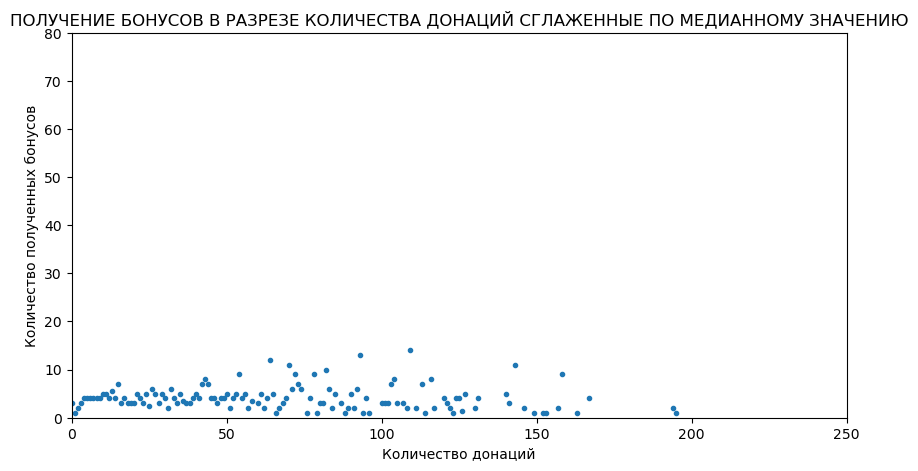

Рассчитаем коэфф-т корреляции между числом донаций и полученными бонусами
0.1515


In [141]:
bonus.pivot_table(index='donation_count', values='bonus_count', aggfunc='median').plot(style='.', xlim=(0, 250), ylim=(0, 80))
plt.title('ПОЛУЧЕНИЕ БОНУСОВ В РАЗРЕЗЕ КОЛИЧЕСТВА ДОНАЦИЙ СГЛАЖЕННЫЕ ПО МЕДИАННОМУ ЗНАЧЕНИЮ')
plt.xlabel('Количество донаций')
plt.ylabel('Количество полученных бонусов')
plt.legend('',frameon=False) # удалим легенду
plt.show()

print('Рассчитаем коэфф-т корреляции между числом донаций и полученными бонусами')
print(round(bonus['donation_count'].corr(bonus['bonus_count']), 4))

Коэффициент корреляции небольшой, всего 0,15. Связь слабая.

In [142]:
donations_bonus_median = bonus.groupby(['donation_count'], as_index=False)['bonus_count'].agg('median').reset_index(drop=True)

Избавимся от выбросов для более гладкого распределения и поиска дальнейших корреляций.

In [143]:
donations_bonus_median = donations_bonus_median[donations_bonus_median['bonus_count'] < 23.0]

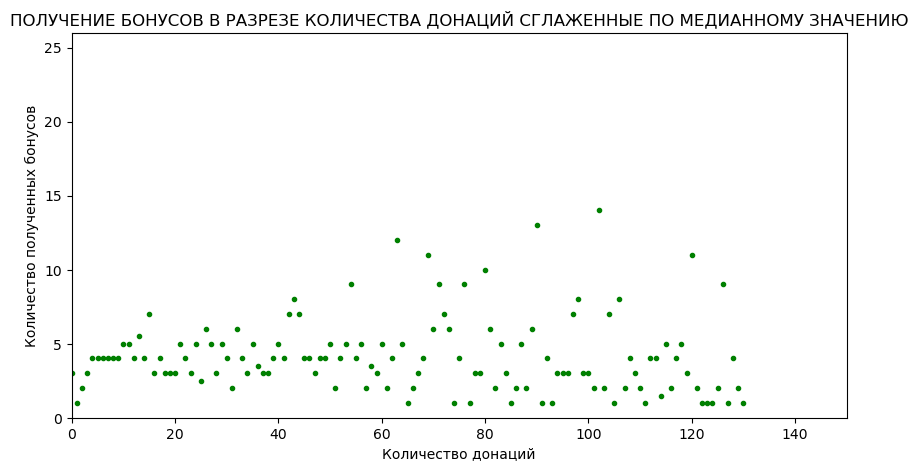

Рассчитаем коэфф-т корреляции между числом донаций и полученными бонусами
0.1515


In [144]:
donations_bonus_median['bonus_count'].plot(style='.', xlim=(0, 150), ylim=(0, 26), color='g')
plt.title('ПОЛУЧЕНИЕ БОНУСОВ В РАЗРЕЗЕ КОЛИЧЕСТВА ДОНАЦИЙ СГЛАЖЕННЫЕ ПО МЕДИАННОМУ ЗНАЧЕНИЮ')
plt.xlabel('Количество донаций')
plt.ylabel('Количество полученных бонусов')
plt.show()

print('Рассчитаем коэфф-т корреляции между числом донаций и полученными бонусами')
print(round(bonus['donation_count'].corr(bonus['bonus_count']), 4))

По *медиане* по данному графику доноры не зависимо от количества донаций однородно получают бонусы от донаций.

Некоторый коэф. корр присутствует, судя по графику, значение 0,15.

Смотрим коэф. корреляции по таблице ниже:

In [145]:
bonus.corr()

,user_id,bonus_count,donation_count
user_id,1.000000,-0.197963,-0.306881
bonus_count,-0.197963,1.000000,0.151509
donation_count,-0.306881,0.151509,1.000000


строми

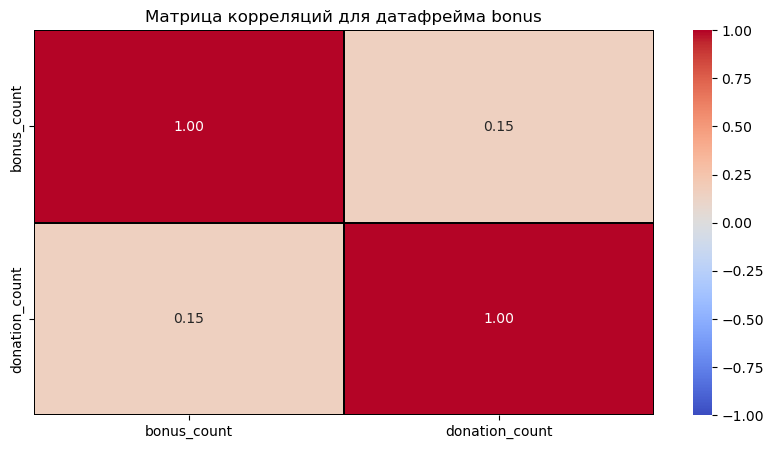

In [146]:
ax = sns.heatmap(bonus[['bonus_count', 'donation_count']].corr(), vmin=-1, vmax=1,
                 cmap='coolwarm', annot=True, fmt='.2f', linecolor='black',
                 linewidths=0.01)
plt.title('Матрица корреляций для датафрейма bonus')
plt.show()

В этой матрице смотрели коэф корреляции чисто по датафрейму bonus.

Коэф корреляции 0.15 - это очень низкая зависимость.  
Матрица корреляций свидетельсвует, что *значительной зависимости количества бонусов от количества донаций нет*.

Посмотрим по `donations_bonus_median`:

In [147]:
donations_bonus_median.corr()

,donation_count,bonus_count
donation_count,1.000000,-0.075259
bonus_count,-0.075259,1.000000


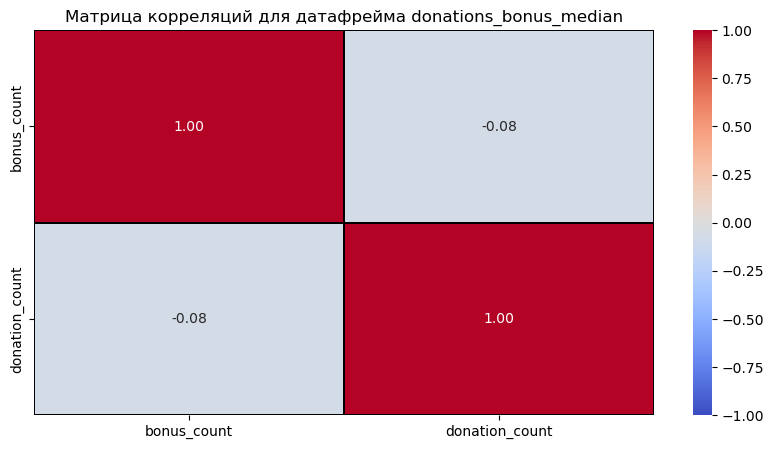

In [148]:
ax = sns.heatmap(donations_bonus_median[['bonus_count', 'donation_count']].corr(), vmin=-1, vmax=1,
                 cmap='coolwarm', annot=True, fmt='.2f', linecolor='black',
                 linewidths=0.01)
plt.title('Матрица корреляций для датафрейма donations_bonus_median')
plt.show()

Здесь же смотрели коэф. корреляции уже по сглаженным медианным значениям датафрейма bonus.

Донации-бонусы по медиане корреляций вообще нет :/

#### 6.2.2 Гипотеза

Выдвиним гипотезу О РАВЕНСТВЕ средних КОЛИЧЕСТВА ДОНАЦИЙ м/д пользователями с бонусами и без (среди пользователей с подтвержденными донациями):

H0: Среднее количество донаций у пользователей получаемых бонусы РАВНО среднему количеству донаций у пользователей не получаемых бонусов.

H1: Среднее количество донаций у пользователей получаемых бонусы НЕ РАВНО среднему количеству донаций у пользователей не получаемых бонусов.

In [149]:
# разделим пользователей на пользователей с бонусами и без
users_Ybon = users[users['Количество_взятых_бонусов'] > 0]
users_Nbon = users[users['Количество_взятых_бонусов'] == 0]

In [150]:
users_Ybon.sample()

,user_id,Пол,Дата_рождения,Почетный_донор,Отвод_от_донации,Цельная_кровь.1,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата_регистрации,Донаций_до_регистрации,Последняя_активность,Подтверждённые_донации,Донаций_на_момент_регистрации,Количество_взятых_бонусов,Дата_получения_почетного_донора,Подтвержденный_почетный_донор
23914,251093,Мужской,1984-11-25,25.04.2025,Нет,4,0,0,0,0,2023-03-27,50.0,2023-11-03,4,50.0,3,NaT,0


In [151]:
users_Ybon = users_Ybon.query('Подтверждённые_донации != 0') # удалим пользователей с бонусами и без донаций

In [152]:
users_Nbon = users_Nbon[users_Nbon['Подтверждённые_донации'] > 0] # отфильтруем пользователей с подтвержденными донациями

In [153]:
# проверим размер выборок
print(users_Ybon['Подтверждённые_донации'].count())
print(users_Nbon['Подтверждённые_донации'].count())

7921
9732


In [154]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    users_Ybon['Подтверждённые_донации'],
    users_Nbon['Подтверждённые_донации'],
    equal_var=False) # False, т.к. выборки достаточно различны по количеству значений
# alpha = задайте значение уровня значимости
alpha = .05
# вывод значения p-value на экран
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

3.1673847471756816e-06
Отвергаем нулевую гипотезу


У пользователей, берущих бонусы, статистически значимое иное среднее количество донаций.

In [155]:
print('На ',round(users_Ybon['Подтверждённые_донации'].mean() / users_Nbon['Подтверждённые_донации'].mean() *100 - 100, 2), '% больше донаций у пользователей с бонусами')

На  15.47 % больше донаций у пользователей с бонусами


In [156]:
mean_countdon_Yb = users_Ybon[users_Ybon['Подтверждённые_донации'] < 40]['Подтверждённые_донации'].mean()
mean_countdon_Nb = users_Nbon[users_Nbon['Подтверждённые_донации'] < 40]['Подтверждённые_донации'].mean()
print('На ',round(mean_countdon_Yb / mean_countdon_Nb *100 - 100, 2), '% больше донаций у пользователей с бонусами среди пользователей с менее 40 донациями')

На  8.41 % больше донаций у пользователей с бонусами среди пользователей с менее 40 донациями


In [157]:
mean_countdon_Yb = users_Ybon[users_Ybon['Подтверждённые_донации'] < 10]['Подтверждённые_донации'].mean()
mean_countdon_Nb = users_Nbon[users_Nbon['Подтверждённые_донации'] < 10]['Подтверждённые_донации'].mean()
print('На ',round(mean_countdon_Yb / mean_countdon_Nb *100 - 100, 2), '% больше донаций у пользователей с бонусами среди пользователей с менее 10 донациями')

На  4.35 % больше донаций у пользователей с бонусами среди пользователей с менее 10 донациями


In [158]:
users_Ybon['Подтверждённые_донации'].median() # медианное значение количества донаций у пользователей с бонусами

2.0

In [159]:
users_Nbon['Подтверждённые_донации'].median() # ... без бонусов

2.0

Медианное количество донаций у пользователей с и без бонусов одинаковое, среднее значение больше у пользователей с бонусами.

Это может свидетельствовать о наличии некоторых пользователей, которые специально ради бонусов сдают кровь.

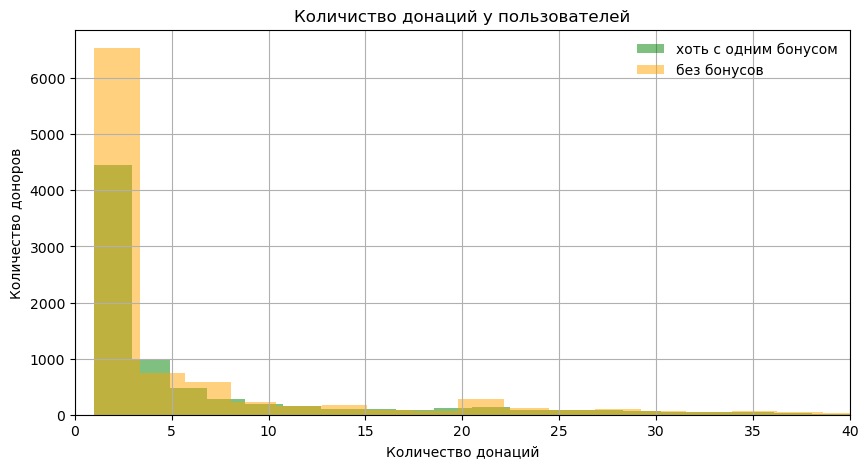

In [160]:
users_Ybon['Подтверждённые_донации'].hist(bins=100, alpha=0.5, color='green')
users_Nbon['Подтверждённые_донации'].hist(bins=100, alpha=0.5, color='orange')
plt.title('Количиство донаций у пользователей')
plt.xlim(0,40)
plt.legend(['хоть с одним бонусом','без бонусов'],frameon=False) # настроим легенду
plt.xlabel('Количество донаций')
plt.ylabel('Количество доноров')

plt.show()

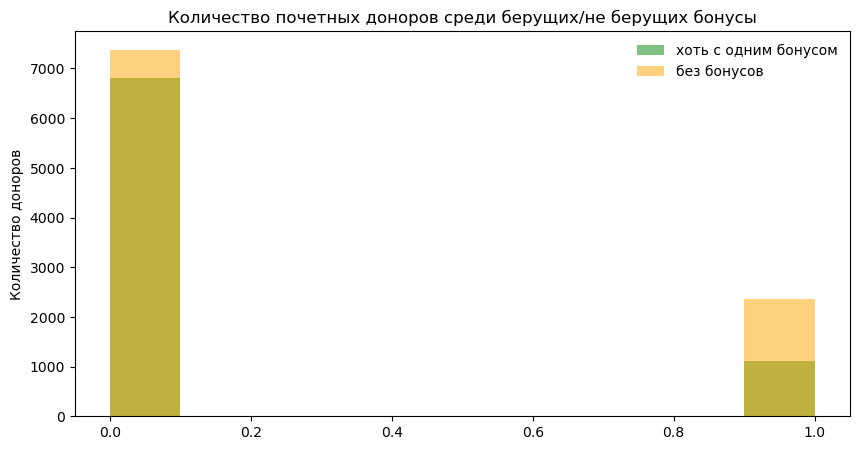

In [161]:
users_Ybon['Подтвержденный_почетный_донор'].hist(alpha=0.5, color='green')
users_Nbon['Подтвержденный_почетный_донор'].hist(alpha=0.5, color='orange')
plt.title('Количество почетных доноров среди берущих/не берущих бонусы')
plt.legend(['хоть с одним бонусом','без бонусов'],frameon=False) # настроим легенду
plt.ylabel('Количество доноров')
plt.grid(False)

plt.show()

1 - почетный донор

0 - не присвоен статус почетного донора

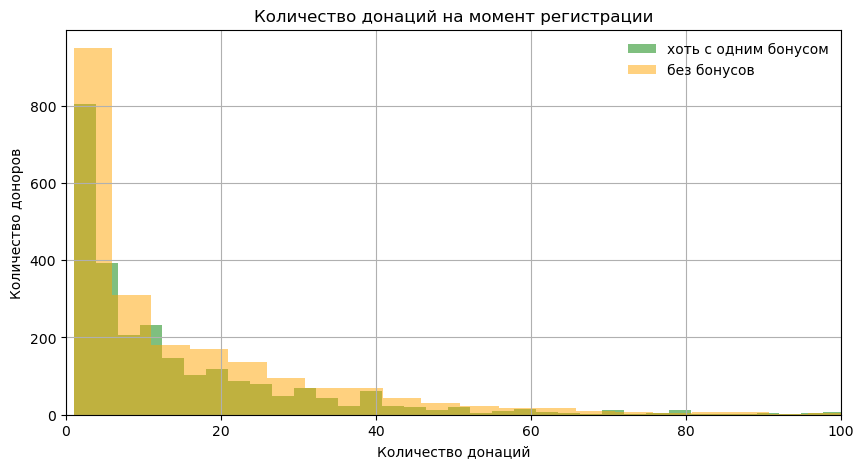

In [162]:
users_Ybon['Донаций_на_момент_регистрации'].hist(bins=70, alpha=0.5, color='green') # зеленый - хоть с одним бонусом
users_Nbon['Донаций_на_момент_регистрации'].hist(bins=70, alpha=0.5, color='orange') # желтый - без бонусов
plt.title('Количество донаций на момент регистрации')
plt.xlim(0,100)
plt.legend(['хоть с одним бонусом','без бонусов'],frameon=False) # настроим легенду
plt.xlabel('Количество донаций')
plt.ylabel('Количество доноров')

plt.show()


Наличие у пользователей не бравших бонусы огромное указанное количество донаций со слов может свидетельствовать о том, что эти пользователи загружали старые свои справки о донациях, которые были осуществлены до регистрации на сайте.

#### 6.2.3 Изучение партнеров и бонусов

In [163]:
# создадим функцию добавления поля "остальные" для круговых диаграмм топ-7
def graph_pie(var):
    var = var.value_counts()
    var[7] = var[7:].values.sum()
    var.index[7]
    var.rename(index={var.index[7]:'остальные'}, inplace = True)
    var = var[:8]
    return var

Посмотрим на Топ 7 партнеров

In [164]:
top_7_partners = graph_pie(bonus['partner']) # применим функцию graph_pie

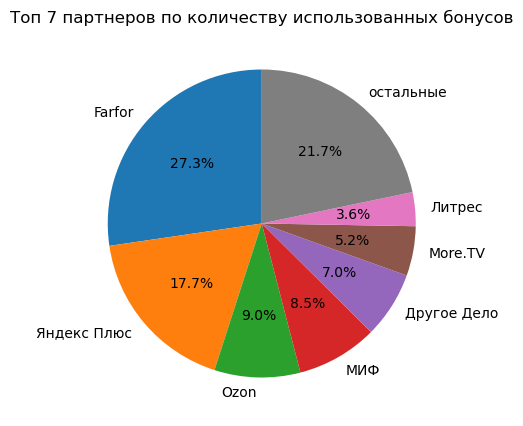

In [165]:
plt.pie(top_7_partners, labels=top_7_partners.index, autopct='%1.1f%%', startangle=90)
plt.title('Топ 7 партнеров по количеству использованных бонусов')
plt.show()

Посмотрим на топ-7 бонусов

In [166]:
top_7_bonuses = graph_pie(bonus['bonus']) # применим функцию graph_pie

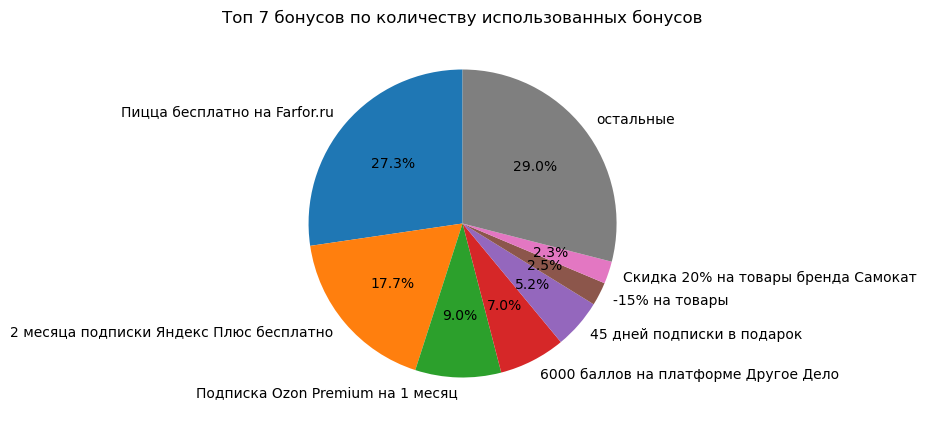

In [167]:
plt.pie(top_7_bonuses, labels=top_7_bonuses.index, autopct='%1.1f%%', startangle=90)
plt.title('Топ 7 бонусов по количеству использованных бонусов')
plt.show()

45% бонусов были взяты пользователями на бесплатную пиццу на Farfor.ru и двухмесячную подписку Яндекс Плюс за 2021-2023 года, а также еще 9% на подписку Озон Премиум 1 месяц.

#### 6.2.4 Исследование в разрезе разных видов крови

In [168]:
pivot_type_blood = users.pivot_table(index='Количество_взятых_бонусов',values=['Цельная_кровь.1','Плазма.1','Тромбоциты.1','Эритроциты.1','Лейкоциты.1'],aggfunc='sum')

In [169]:
for column in pivot_type_blood.columns:
    pivot_type_blood.loc[1,column] = pivot_type_blood.loc[:,column].sum() # просуммируем все столбцы с бонусами
pivot_type_blood = pivot_type_blood.loc[:1] # удалим лишние строки

# уберем лишнее в названии вида крови
name_column = list()
for x in list(pivot_type_blood.columns):
  y = x.split('.1')[0]
  name_column.append(y)

pivot_type_blood.columns = name_column
pivot_type_blood

,Лейкоциты,Плазма,Тромбоциты,Цельная_кровь,Эритроциты
Количество_взятых_бонусов,,,,,
0,13,17978,6135,44734,95
1,28,34629,13936,84982,193


1 - это значит бонус брали (не зависимо от количества бонусов)  
0 - значит бонус не брали

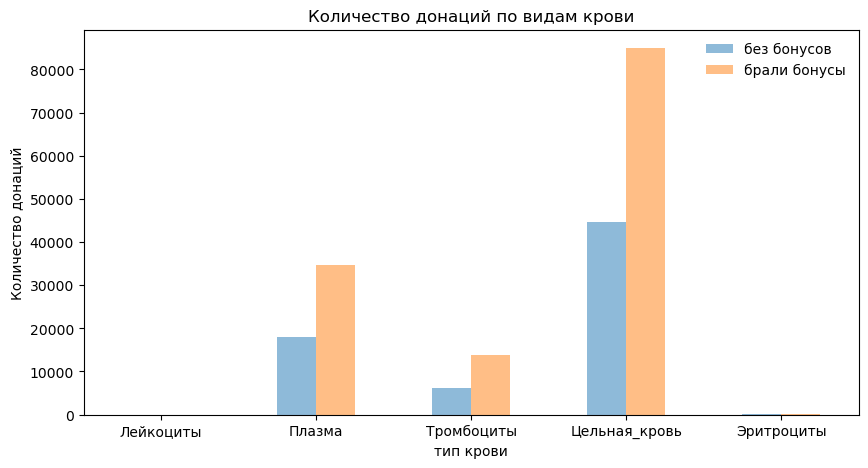

In [170]:
pivot_type_blood.T.plot(alpha=0.5, kind='bar')
plt.title('Количество донаций по видам крови')
plt.xlabel('тип крови')
plt.ylabel('Количество донаций')
plt.xticks(rotation = 0)
plt.legend(['без бонусов','брали бонусы'],frameon=False) # настроим легенду
plt.show()

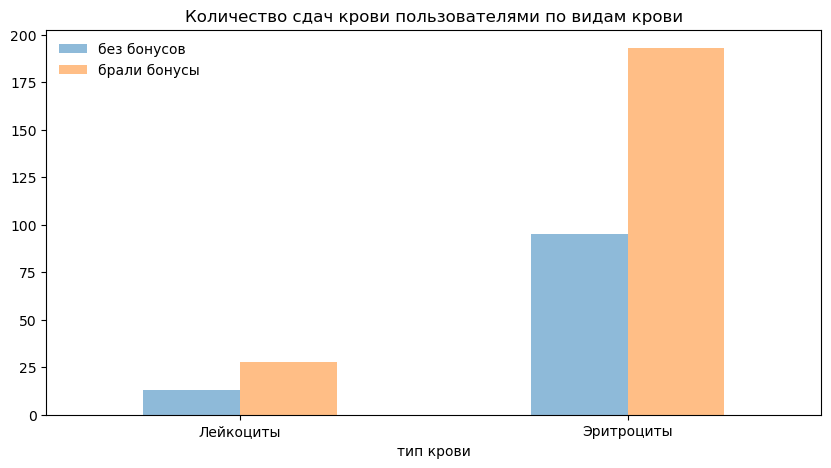

In [171]:
pivot_type_blood[['Лейкоциты','Эритроциты']].T.plot(alpha=0.5, kind='bar')
plt.title('Количество сдач крови пользователями по видам крови')
plt.xlabel('тип крови')
plt.xticks(rotation=0)
plt.legend(['без бонусов','брали бонусы'],frameon=False) # настроим легенду
plt.show()

Зависимости получения бонуса от сдачи разных видов крови не установлено.

#### 6.2.5 Анализ пользователей планирующих / не планирующих донации

Посмотим отличаются ли пользователи с/без бонусов от тех которые планируют донации.

In [172]:
url_plan = 'https://drive.google.com/file/d/1VsZT9KbdJ4bbnjmFkKewdYK_mBYBOwmk/view'
url_plan='https://drive.google.com/uc?id=' + url_plan.split('/')[-2]
plan_don = pd.read_csv(url_plan, index_col=0) # загрузим датасет с планом донаций
plan_don = plan_don.reset_index(col_level=True)

In [173]:
plan = plan_don.copy()
plan = plan[['id','user_id','donation_date','planned_date','donation_type','status','certificate']] # выберем нужные столбцы

# изменим тип данных
plan['planned_date'] = pd.to_datetime(plan['planned_date'])
plan['donation_date'] = pd.to_datetime(plan['donation_date'])

plan = plan[plan['donation_date'].dt.year >= 2021] # отфильтруем датасет по необходимым годам
plan.head()

,id,user_id,donation_date,planned_date,donation_type,status,certificate
0,27870,262549,2023-11-14,2023-11-13,Безвозмездно,донация запланирована,Нет
1,27869,203,2023-11-15,2023-11-13,Безвозмездно,донация запланирована,Нет
2,27868,274735,2023-11-14,2023-11-13,Безвозмездно,планирование отменено,Нет
3,27867,260348,2024-01-19,2023-11-13,Безвозмездно,донация запланирована,Нет
4,27866,232312,2023-11-29,2023-11-13,Безвозмездно,донация запланирована,Нет


In [174]:
plan['status'].value_counts()

донация запланирована                                 10516
запланированная донация добавлена                      8587
планирование отменено                                  7191
отказ прикрепить справку к прошедшему планированию      743
Name: status, dtype: int64

Будем считать всех вышеперечисленных пользователей как пользователей, пользующихся функцией планирования, в том числе пользователей, которые отменяли свои донации или их не подтверждали справкой.

In [175]:
plan = pd.DataFrame(data = (plan['user_id'].unique()), columns=['user_id']) # выберем уникальных пользователей и заменим датасет

In [176]:
plan['Планирование_донации'] = 'была запланирована' # создадим новую колонку со статусом планирования донации

In [177]:
type_plan = users.merge(plan, how='left', on='user_id') # присоединим таблицу с планом к датасету пользователей сайта

In [178]:
type_plan['Планирование_донации'] = type_plan['Планирование_донации'].fillna('не планировалась') # заполним пустые поля статусом "не планировалась"

In [179]:
# создадим сводную таблицу
pivot_type_plan = type_plan.pivot_table(index='Планирование_донации',values='Количество_взятых_бонусов',aggfunc=['sum','count']).stack().droplevel(1)
pivot_type_plan = pivot_type_plan.rename(columns={'sum':'Сумма взятых бонусов','count':'Количество пользователей'})

In [180]:
pivot_type_plan['Сумма_бонусов_divide_количество_пользователей'] = pivot_type_plan['Сумма взятых бонусов'] / pivot_type_plan['Количество пользователей']
pivot_type_plan

,Сумма взятых бонусов,Количество пользователей,Сумма_бонусов_divide_количество_пользователей
Планирование_донации,,,
была запланирована,6550,14019,0.467223
не планировалась,9813,74496,0.131725


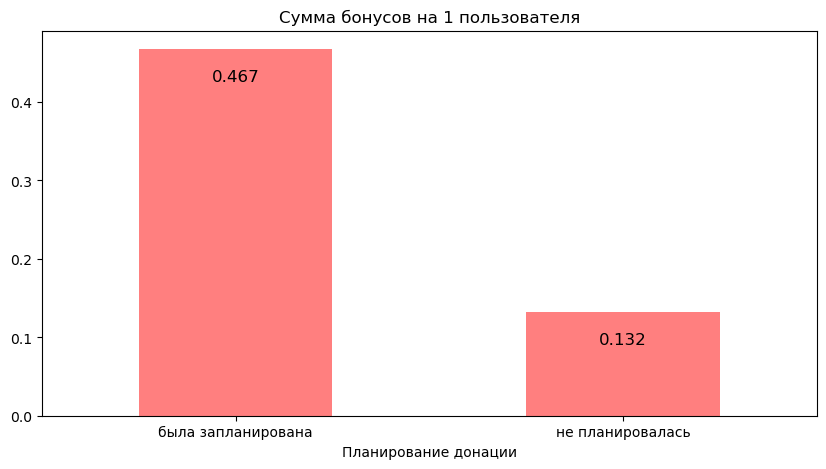

In [181]:
chart = pivot_type_plan.plot(y='Сумма_бонусов_divide_количество_пользователей', alpha=0.5, kind='bar',color='red')
plt.title('Сумма бонусов на 1 пользователя')
plt.xlabel('Планирование донации')
plt.xticks(rotation=0)

plt.legend('',frameon=False) # удалим легенду
chart.bar_label(chart.containers[0], fmt='%.3f', padding=-25, fontsize=12) # настроим подписи на барах

plt.show()

В 3,5 раза пользователи с запланированной донацией чаще берут бонусы, чем пользователи, которые не планируют свои донации.

С запланированной донацией считали любого пользователя пользующегося данной функцией не зависимо от того сумел ли он подтвердить свою донацию или ее отменил.

#### 6.2.6 Сегментация пользователей по количеству донаций

In [182]:
# СОЗДАДИМ функцию создания столбца со значениями назначенных групп рользователей по количеству донаций
def function_group_donation(x):
    if x > 0 and x <= 2:
        return '1-2 донации'
    elif x > 2 and x <= 10:
        return '3-10 донаций'
    elif x > 10:
        return 'более 10 донаций'

In [183]:
users_don_group = users.query('Донаций_до_регистрации == 0')
users_don_group_copy = users_don_group.copy()
users_don_group_copy['group_count_donation'] = users_don_group_copy['Подтверждённые_донации'].apply(function_group_donation)

In [184]:
users_group_pivot = users_don_group_copy.pivot_table(index='group_count_donation', values=['Количество_взятых_бонусов'], aggfunc=['count','sum']).stack()
users_group_pivot = users_group_pivot.rename(columns={'count':'Количество пользователей воспользовавшиеся бонусами', 'sum':'Суммарное количество взятых бонусов'}).droplevel(1)
users_group_pivot

,Количество пользователей воспользовавшиеся бонусами,Суммарное количество взятых бонусов
group_count_donation,,
1-2 донации,159,130
3-10 донаций,134,283
более 10 донаций,48,176


In [185]:
users_mean_pivot = users_don_group_copy.pivot_table(index='group_count_donation', values=['Подтверждённые_донации'], aggfunc=['mean']).stack()
users_mean_pivot = users_mean_pivot.rename(columns={'mean':'Среднее количество донаций в группе'}).droplevel(1)
users_group_pivot = users_group_pivot.merge(users_mean_pivot, on='group_count_donation', how='left')

In [186]:
users_group_pivot['Количество пользователей / среднее число донаций в группе'] = users_group_pivot['Количество пользователей воспользовавшиеся бонусами'] / users_group_pivot['Среднее количество донаций в группе']
users_group_pivot['Сумма бонусов / среднее число донаций в группе'] = users_group_pivot['Суммарное количество взятых бонусов'] / users_group_pivot['Среднее количество донаций в группе']
users_group_pivot

,Количество пользователей воспользовавшиеся бонусами,Суммарное количество взятых бонусов,Среднее количество донаций в группе,Количество пользователей / среднее число донаций в группе,Сумма бонусов / среднее число донаций в группе
group_count_donation,,,,,
1-2 донации,159,130,1.264151,125.776119,102.835821
3-10 донаций,134,283,5.305970,25.254571,53.336146
более 10 донаций,48,176,20.125000,2.385093,8.745342


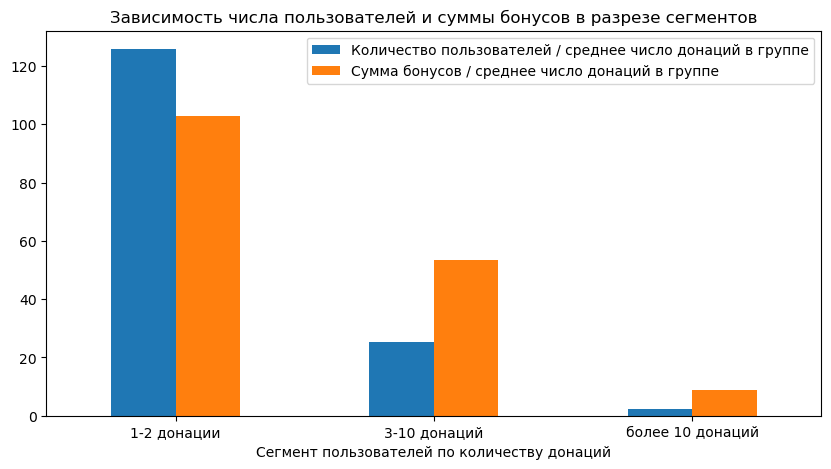

In [187]:
plt.rcParams["figure.figsize"] = (10,5)
users_group_pivot.plot(y=['Количество пользователей / среднее число донаций в группе','Сумма бонусов / среднее число донаций в группе'], kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Сегмент пользователей по количеству донаций')
plt.title('Зависимость числа пользователей и суммы бонусов в разрезе сегментов')
plt.show()

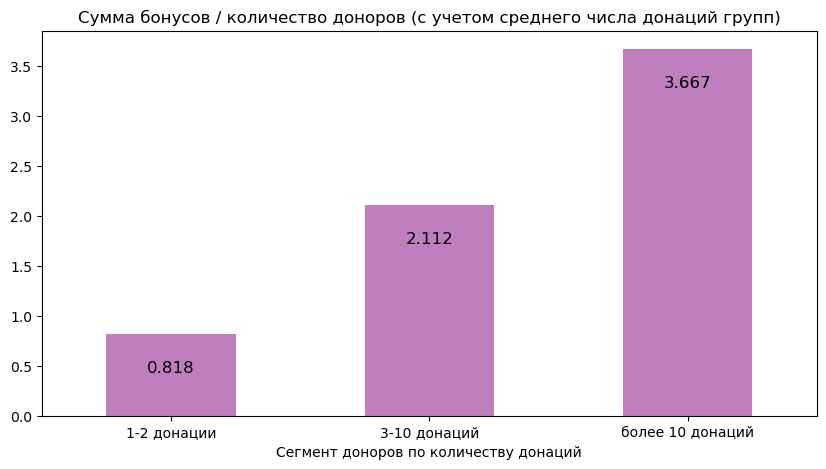

In [188]:
plt.rcParams["figure.figsize"] = (10,5)
users_group_pivot['Сумма бонусов / количество доноров (с учетом среднего числа донаций групп)'] = users_group_pivot['Сумма бонусов / среднее число донаций в группе'] / users_group_pivot['Количество пользователей / среднее число донаций в группе']
chart = users_group_pivot.plot(y='Сумма бонусов / количество доноров (с учетом среднего числа донаций групп)', kind='bar',color='purple', alpha=0.5)
plt.xlabel('Сегмент доноров по количеству донаций')
plt.xticks(rotation=0)
plt.title('Сумма бонусов / количество доноров (с учетом среднего числа донаций групп)')
plt.legend('',frameon=False)
chart.bar_label(chart.containers[0], fmt='%.3f', padding=-30, fontsize=12) # настроим подписи на барах
plt.show()

In [189]:
# Сумма бонусов / количество пользователей - Это значение еще делилось на среднее число донаций в соответствующей группе, поэтому в названии присутствует пояснение в скобках

Среди пользователей, у которых есть подтвержденные донации и пользователей которые впервые с платформой начали сдавать кровь (указали 0 донаций до регистрации), в пересчете на среднее число донаций: чем больше у пользователя донаций - тем больше они берут бонусов.

Другими словами, зависимость количества бонусов от количества донаций напоминает о геометрической прогрессии, - чем больше у пользователей подтвержденных донаций - тем еще больше они берут бонусы!

## 6.3 ВЫВОД по анализу влияния бонусов на пользовательскую активность:

<div style="border:solid red 2px; padding: 20px">
Не воспользовались бонусами большинство - 80 594 чел. – 91% всех пользователей (за 2021, 2022 и не полный 2023 годы).

Если 100% - это количество людей, бравших в установленный период бонусы, то:

-- большинство людей получили бонусы при 1 донации - 4 437 (56%),  
-- при 2 донациях – 1 695 (21%),  
что может свидетельствовать, что как раз эти люди могли быть дополнительно мотивированны бонусами, чтобы сдать кровь.

Наблюдается убывающая тенденция количества полученных бонусов от количества донаций у пользователей.

Те люди, что сдают кровь чаще 6 и более раз, во-первых, их просто меньше, во-вторых, их могут мотивировать совершенно другие мотивы, нежели получение бонусов. Но люди стабильно получают бонусы даже при 50+ количествах донаций, значит для них это важный весомый аргумент.

По медиане доноры не зависимо от количества донаций однородно получают бонусы от донаций.  
Медианное количество донаций у пользователей с и без бонусов одинаковое – равно 2, среднее значение больше у пользователей с бонусами.  
Это может свидетельствовать о наличии некоторых пользователей, которые специально ради бонусов сдают кровь.  

Коэффициент корреляции между числом донаций и полученными бонусами незначительный, значение 0,15.

Не подтвердили гипотезу о равестве средних КОЛИЧЕСТВА ДОНАЦИЙ м/д пользователями с бонусами и без. У пользователей, берущих бонусы, статистически значимое иное среднее количество донаций:  
•	На  15.47 % больше донаций у пользователей с бонусами (среди всех)  
•	На  8.41 % больше донаций у пользователей с бонусами среди пользователей с менее 40 донациями  
•	На  4.35 % больше донаций у пользователей с бонусами среди пользователей с менее 10 донациями  

Топ 3 бонусов по количеству использованных бонусов:
1.	бесплатная пицца на Farfor.ru - 27,3%;
2.	2 месяца подписки Яндекс Плюс бесплатно – 17,7%;
3.	подписка Ozon Premium на 1 месяц – 9%.

В 3,5 раза пользователи с запланированной донацией чаще берут бонусы, чем пользователи, которые не планируют свои донации. С запланированной донацией считали любого пользователя пользующегося данной функцией не зависимо от того сумел ли он подтвердить свою донацию или ее отменил.

Среди пользователей, у которых есть подтвержденные донации и пользователей которые впервые с платформой начали сдавать кровь (указали 0 донаций до регистрации), в пересчете на среднее число донаций: чем больше у пользователя донаций - тем больше они берут бонусов.

Другими словами, зависимость количества бонусов от количества донаций напоминает о геометрической прогрессии, - чем больше у пользователей подтвержденных донаций - тем еще больше они берут бонусы!

Зависимости получения бонуса от сдачи разных видов крови не установлено.
